# Unsupervised Graph Embeddings - Shallow methods

## Setup

In [ ]:
!pip install git+https://github.com/palash1992/GEM.git
!pip install karateclub
!pip install node2vec
!pip install python-Levenshtein
!pip install gensim==3.8.0
!pip install -U Ipython

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from gem.embedding.gf import GraphFactorization
from karateclub.node_embedding.neighbourhood.grarep import GraRep
from gem.embedding.hope import HOPE
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk
from node2vec import Node2Vec
import random
from IPython.display import Code
import inspect
from karateclub import Graph2Vec
from node2vec.edges import HadamardEmbedder

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## Theory

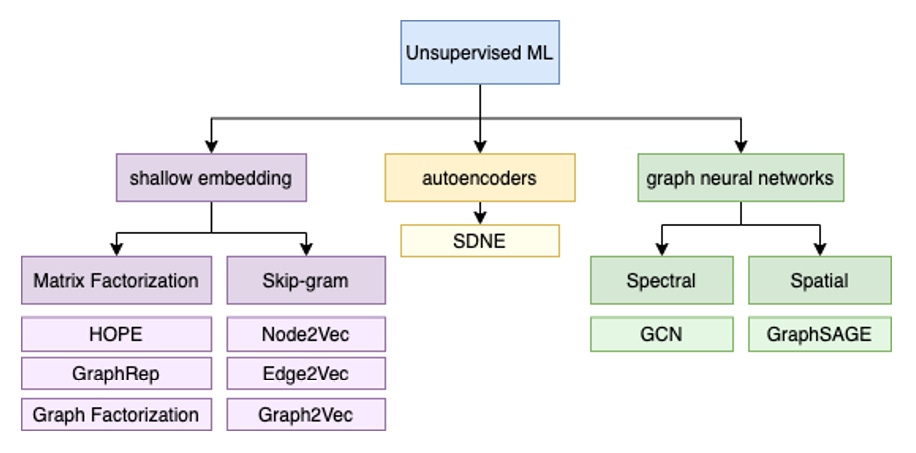

### Shallow embedding methods
These methods are able to learn and return only the embedding values for the learned input data. Generally speaking, all the unsupervised embedding algorithms based on matrix factorization use the same principle. They all factorize an input graph expressed as a matrix in different components (commonly knows as matrix factorization). The main difference between each method lies in the loss function used during the optimization process. Indeed, different loss functions allow creating an embedding space that emphasizes specific properties of the input graph.

## Graph Factorization

The GF algorithm was one of the first models to reach good computational performance in order to perform the node embedding of a given graph. The loss function used in this method was mainly designed to improve GF performances and scalability. Indeed, the solution generated by this method could be noisy. Moreover, it should be noted, by looking at its matrix factorization formulation, that GF performs a strong symmetric factorization. This property is particularly suitable for undirected graphs, where the adjacency matrix is symmetric, but could be a potential limitation for undirected graphs.

In [ ]:
Code(inspect.getsource(GraphFactorization), language='python')

In [ ]:
Path("gem/intermediate").mkdir(parents=True, exist_ok=True)

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)

In [ ]:
gf = GraphFactorization(d=2, data_set=None, max_iter=10000, eta=1*10**-4, regu=1.0)
gf.learn_embedding(G)

In [ ]:
draw_graph(G)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    v = gf.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

## GraphRep

Graph representation with global structure information (GraphRep), such as HOPE, allows us to preserve higher-order proximity without forcing its embeddings to have symmetric properties.

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

We initialize the GraRep class from the karateclub library. In this implementation, the dimension parameter represents the dimension of the embedding space, while the order parameter defines the maximum number of orders of proximity between nodes. The number of columns of the final embedding matrix (stored, in the example, in the embeddings variable) is `dimension x order`, since, as we said, for each proximity order an embedding is computed and concatenated in the final embedding matrix.

In [ ]:
gr = GraRep(dimensions=2,order=3)
gr.fit(G)

In [ ]:
embeddings = gr.get_embedding()
embeddings.shape

To specify, since two dimensions are computed in the example, embeddings[:,:2] represents the embedding obtained for k=1, embeddings[:,2:4] for k=2, and embeddings[:,4:] for k=3. The results of the code are shown in the following graph:

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

for x in G.nodes():
    v = gr.get_embedding()[x]
    ax[0].scatter(v[0],v[1], s=1000)
    ax[0].annotate(str(x), (v[0],v[1]), fontsize=12)
    ax[0].set_title('k=1')
    ax[1].scatter(v[2],v[3], s=1000)
    ax[1].annotate(str(x), (v[2],v[3]), fontsize=12)
    ax[1].set_title('k=2')
    ax[2].scatter(v[4],v[5], s=1000)
    ax[2].annotate(str(x), (v[4],v[5]), fontsize=12)
    ax[2].set_title('k=3')

plt.show()

## HOPE

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

In [ ]:
hp = HOPE(d=4, beta=0.01)
hp.learn_embedding(G)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = hp.get_embedding()[x,2:]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=20)

## DeepWalk

*fig: All the steps used by the DeepWalk algorithm to generate the node embedding of a given graph*

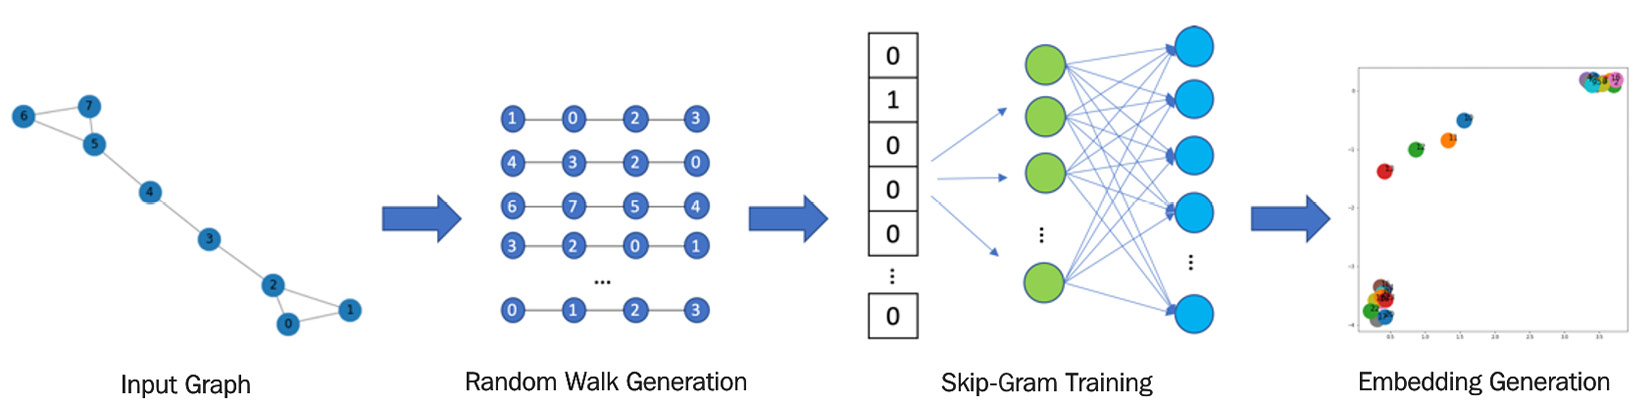

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

In [ ]:
Code(inspect.getsource(DeepWalk), language='python')

In [ ]:
dw = DeepWalk(dimensions=2)
dw.fit(G)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = dw.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

## Node2Vec

The Node2Vec algorithm can be seen as an extension of DeepWalk. Indeed, as with DeepWalk, Node2Vec also generates a set of random walks used as input to a skip-gram model. Once trained, the hidden layers of the skip-gram model are used to generate the embedding of the node in the graph. The main difference between the two algorithms lies in the way the random walks are generated.

Indeed, if DeepWalk generates random walks without using any bias, in Node2Vec a new technique to generate biased random walks on the graph is introduced. The algorithm to generate the random walks combines graph exploration by merging Breadth-First Search (BFS) and Depth-First Search (DFS). The way those two algorithms are combined in the random walk's generation is regularized by two parameters p, and q. p defines the probability of a random walk getting back to the previous node, while q defines the probability that a random walk can pass through a previously unseen part of the graph.

Due to this combination, Node2Vec can preserve high-order proximities by preserving local structures in the graph as well as global community structures. This new method of random walk generation allows solving the limitation of DeepWalk preserving the local neighborhood properties of the node.

In [ ]:
Code(inspect.getsource(Node2Vec), language='python')

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

In [ ]:
node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)
embeddings = model.wv

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = model.wv[str(x)]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

## Edge2Vec

Contrary to the other embedding function, the Edge to Vector (Edge2Vec) algorithm generates the embedding space on edges, instead of nodes. This algorithm is a simple side effect of the embedding generated by using Node2Vec. The main idea is to use the node embedding of two adjacent nodes to perform some basic mathematical operations in order to extract the embedding of the edge connecting them.

The operators described in the below table can be used in order to compute the embedding of their edge:

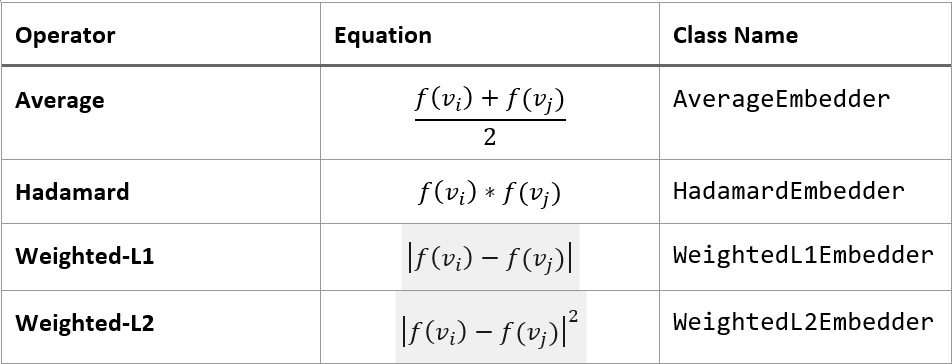

In [ ]:
Code(inspect.getsource(HadamardEmbedder), language='python')

In [ ]:
from node2vec.edges import EdgeEmbedder
Code(inspect.getsource(EdgeEmbedder), language='python')

In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():
    
    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

## Graph2Vec

To specify, given a set of graphs, the Graph2Vec algorithms generate an embedding space where each point represents a graph. This algorithm generates its embedding using an evolution of the Word2Vec skip-gram model known as Document to Vector (Doc2Vec). We can graphically see a simplification of this model as follows:

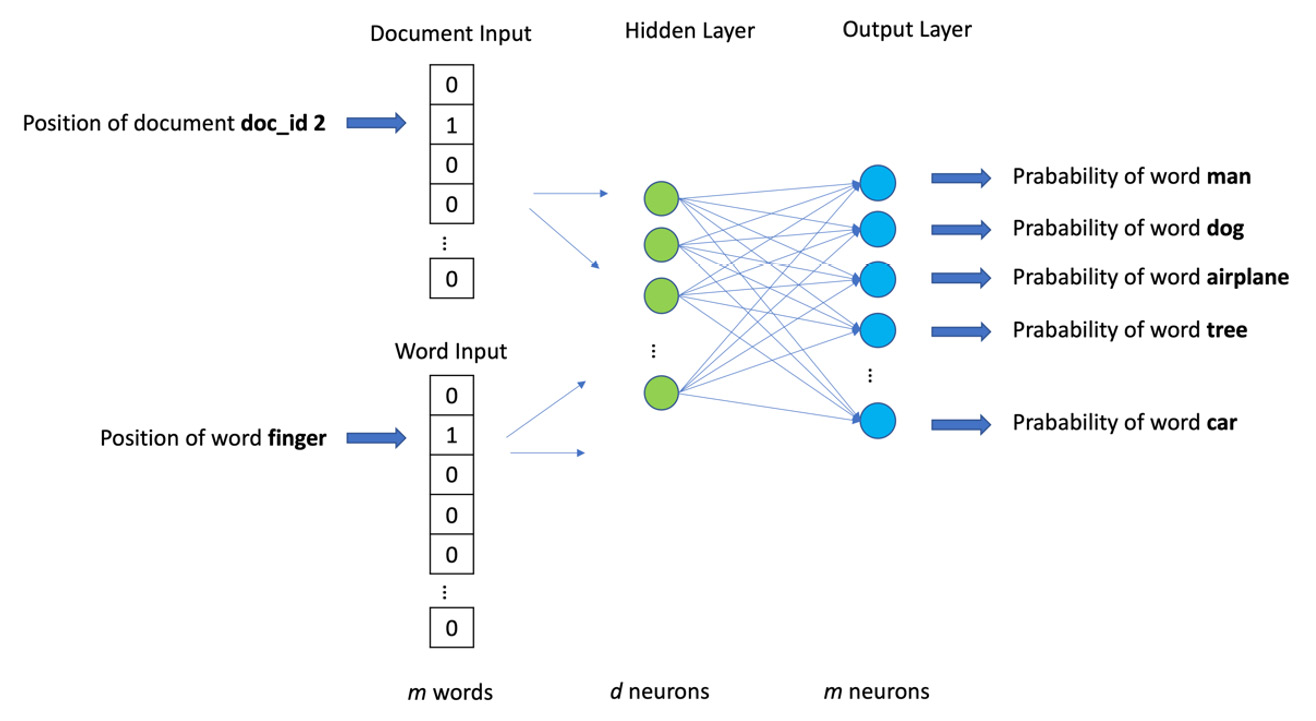

In [ ]:
n_graphs = 20

def generate_radom():
    n = random.randint(6, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p), [n,k,p]

Gs = [generate_radom() for x in range(n_graphs)]

model = Graph2Vec(dimensions=2, wl_iterations=10)
model.fit([x[0] for x in Gs])
embeddings = model.get_embedding()

fig, ax = plt.subplots(figsize=(10,10))

for i,vec in enumerate(embeddings):
    
    ax.scatter(vec[0],vec[1], s=1000)
    ax.annotate(str(i), (vec[0],vec[1]), fontsize=40)